## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt


##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
5613,00001507_001.png,No Finding,1,1507,14,F,PA,2048,2500,0.168,0.168,NaN,/data/images_002/images/00001507_001.png
74568,00018304_014.png,Mass,14,18304,67,M,PA,2992,2991,0.143,0.143,NaN,/data/images_008/images/00018304_014.png
58199,00014397_003.png,No Finding,3,14397,56,F,AP,2500,2048,0.168,0.168,NaN,/data/images_007/images/00014397_003.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column
from itertools import chain

all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))

for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.head()

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
conditions = [ (all_xray_df['Pneumonia']==1.0),(all_xray_df['Pneumonia']==0.0)]
values = ['Pneumonia','No_Pneumonia']
all_xray_df['pneumonia_class'] = np.select(conditions, values)

print('Count of Penumonia cases: ' +str(len(all_xray_df[all_xray_df.pneumonia_class =='Pneumonia'])))
print('Count of Non Penumonia cases: ' +str(len(all_xray_df[all_xray_df.pneumonia_class =='No_Pneumonia'])))

Count of Penumonia cases: 1431
Count of Non Penumonia cases: 110689


## Create your training and testing data:

In [5]:
import sklearn.model_selection as skl
from random import sample

def splitdatafair(df,isvaldata):
    p_inds = df[df.pneumonia_class =='Pneumonia'].index.tolist()
    np_inds = df[df.pneumonia_class =='No_Pneumonia'].index.tolist()
    if isvaldata:
        np_sample = sample(np_inds,4*len(p_inds))
    else:
        np_sample = sample(np_inds,len(p_inds))
    df = df.loc[p_inds + np_sample]
    return df

def create_splits(xraydata):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
        
        
    train_data, val_data = skl.train_test_split(xraydata, 
                                   test_size = 0.2,
                                   stratify =xraydata['Pneumonia']
                                   )
    print("Testing split of train data Pneomonia vs no Pneomonia" +str(train_data['Pneumonia'].sum()/len(train_data)))
    print("Testing split of val. data Pneomonia vs no Pneomonia" +str(val_data['Pneumonia'].sum()/len(val_data)))

    train_data=splitdatafair(train_data,False)
    val_data=splitdatafair(val_data,True)
    print("Testing split of train data Pneomonia vs no Pneomonia" +str(train_data['Pneumonia'].sum()/len(train_data)))
    print("Testing split of val. data Pneomonia vs no Pneomonia" +str(val_data['Pneumonia'].sum()/len(val_data)))
    return train_data, val_data

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [6]:
from keras.preprocessing.image import ImageDataGenerator

def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package

    my_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              zoom_range=0.1)
    
    return my_idg


def make_train_gen(xraydata,IMG_SIZE):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
        
    my_train_idg=my_image_augmentation()
    train_gen = my_train_idg.flow_from_dataframe(dataframe=xraydata, 
                                          directory=None, 
                                          x_col ='path' ,
                                          y_col = 'pneumonia_class',
                                          class_mode = 'binary',
                                          target_size = (IMG_SIZE,IMG_SIZE), 
                                          batch_size =128
                                          )
    return train_gen


def make_val_gen(xraydata,IMG_SIZE):
    my_val_idg=ImageDataGenerator(rescale=1. / 255.0)
    val_gen = my_val_idg.flow_from_dataframe(dataframe = xraydata, 
                                              directory=None, 
                                              x_col = 'path',
                                              y_col = 'pneumonia_class',
                                              class_mode = 'binary',
                                              target_size = (IMG_SIZE,IMG_SIZE),
                                              batch_size =32 ) 
    return val_gen

Using TensorFlow backend.


In [7]:
#Split data into validation and training.
IMG_SIZE=224
train_data,val_data=create_splits(all_xray_df)

## May want to pull a single large batch of random validation data for testing after each epoch:
val_gen=make_val_gen(val_data,IMG_SIZE)
valX, valY = val_gen.next()



Testing split of train data Pneomonia vs no Pneomonia0.012765340706386016
Testing split of val. data Pneomonia vs no Pneomonia0.012754191937210132
Testing split of train data Pneomonia vs no Pneomonia0.5
Testing split of val. data Pneomonia vs no Pneomonia0.2
Found 1430 validated image filenames belonging to 2 classes.


Found 2290 validated image filenames belonging to 2 classes.


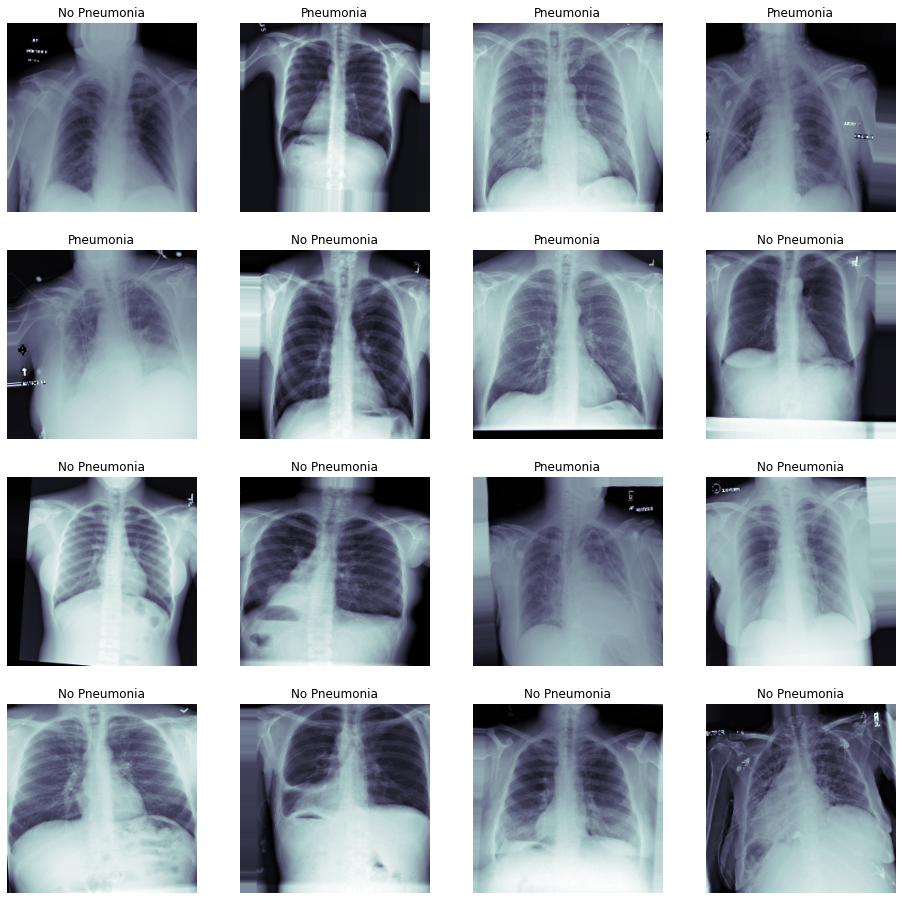

In [8]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation
train_gen=make_train_gen(train_data,IMG_SIZE)
t_x, t_y = train_gen.next()
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [9]:
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam,SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.applications.resnet import ResNet50 #conv5_block3_3_conv

def load_pretrained_model(lay_of_interest):
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer(lay_of_interest)
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
   
    return vgg_model


In [10]:
def build_my_model(optimizer,loss,metrics,lay_of_interest,num_layer):
    
    my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    my_model.add(load_pretrained_model(lay_of_interest))
    
    for layer in my_model.layers[0:num_layer]:
        layer.trainable = False
    
    my_model.add(Flatten())
    my_model.add(Dropout(0.25))
    
    my_model.add(Dense(2048, activation='relu'))
    my_model.add(Dropout(0.25))

    #my_model.add(Dense(1024, activation='relu'))
    #my_model.add(Dropout(0.4))

    my_model.add(Dense(512, activation='relu'))
    my_model.add(Dropout(0.25))
    
    #my_model.add(Dense(256, activation='relu'))
    #my_model.add(Dropout(0.25))

    my_model.add(Dense(1, activation='sigmoid'))

# Add a dense (aka. fully-connected) layer.
# Change the activation function to sigmoid 
# so output of the last layer is in the range of [0,1] 
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    # also make sure you set your optimizer, loss function, and metrics to monitor
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [11]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="{}_model.best.hdf5".format('xray_class')
checkpoint = ModelCheckpoint(weight_path, 
                              monitor= 'val_loss', 
                              verbose=1, 
                              save_best_only=True, 
                              mode ='auto',
                              save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss',
                       mode= 'auto', 
                       patience=10)

callbacks_list = [checkpoint,early] #early

### Start training! 

In [12]:
## train your model
optimizer = Adam(lr=0.0001) #SGD(lr=0.01)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy'] #,'Recall','Precision','AUC'
layer_of_interest= 'block5_pool' #'conv5_block3_3_bn' 
num_layer= 17 #170 
#Build your preferred model

my_model=build_my_model(optimizer,loss,metrics,layer_of_interest,num_layer)
history = my_model.fit_generator(train_gen, 
                           validation_data = val_gen, 
                           epochs = 25, 
                           callbacks = callbacks_list)

Epoch 1/25
18/18 [==============================] - 87s 5s/step - loss: 0.8108 - binary_accuracy: 0.5288 - val_loss: 0.8348 - val_binary_accuracy: 0.2049

Epoch 00001: val_loss improved from inf to 0.83476, saving model to xray_class_model.best.hdf5
Epoch 2/25
18/18 [==============================] - 56s 3s/step - loss: 0.7082 - binary_accuracy: 0.5568 - val_loss: 1.0846 - val_binary_accuracy: 0.2448

Epoch 00002: val_loss did not improve from 0.83476
Epoch 3/25
18/18 [==============================] - 61s 3s/step - loss: 0.6945 - binary_accuracy: 0.5633 - val_loss: 0.8713 - val_binary_accuracy: 0.4098

Epoch 00003: val_loss did not improve from 0.83476
Epoch 4/25
18/18 [==============================] - 62s 3s/step - loss: 0.6839 - binary_accuracy: 0.5738 - val_loss: 0.5328 - val_binary_accuracy: 0.7168

Epoch 00004: val_loss improved from 0.83476 to 0.53278, saving model to xray_class_model.best.hdf5
Epoch 5/25
18/18 [==============================] - 62s 3s/step - loss: 0.6831 - bin

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [13]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
from keras.models import model_from_json

def load_model(model_path, weight_path):
    #load model from json
    jsonfile=open(model_path,'r')
    loaded_model_json=jsonfile.read()
    jsonfile.close()
    loaded_model = model_from_json(loaded_model_json)
    #load weights now
    loaded_model.load_weights(weight_path)
    loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])
    return loaded_model
model_path = 'my_model.json'#path to saved model
weight_path ='xray_class_model.best.hdf5'#path to saved best weights
newmodel=load_model(model_path,weight_path)
pred_Y = newmodel.predict(val_gen, verbose = True) 


ValueError: You are trying to load a weight file containing 4 layers into a model with 6 layers.

In [ ]:

from sklearn.metrics import roc_curve, auc,average_recall_score,precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix

def plot_roc_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    
# function to plot the precision_recall_curve. You can utilizat precision_recall_curve imported above
def plot_precision_recall_curve(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(recall, precision, label = '%s (AP Score:%0.2f)\n (AR Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y),average_recall_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')

# function to calculate the F1 score
def  calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)
    
#Also consider plotting the history of your model training:

def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

In [ ]:
## plot history
plot_history(history)

In [ ]:
## plot figures ROC-Curve
plot_roc_curve(val_gen.classes ,pred_Y)

In [ ]:
## plot figures Precision-Recall Curve
plot_precision_recall_curve(val_gen.classes, pred_Y)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [ ]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

precision, recall, thresholds = precision_recall_curve(val_gen.classes, pred_Y)
f1score = calc_f1(precision,recall)
optimal_idx = np.argmax(f1score)
print('Best Threshold from Prec-Recall curve=%f, F-Score=%.3f' % (thresholds[optimal_idx], f1score[optimal_idx]))
YOUR_THRESHOLD = thresholds[optimal_idx]

#determine best threshold
fpr, tpr, thresholds = roc_curve(val_gen.classes, pred_Y)
optimal_idx = np.argmax(tpr - fpr)
print('Best Threshold from ROC: ' +str(thresholds[optimal_idx]))


In [ ]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > YOUR_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > YOUR_THRESHOLD: 
             c_ax.set_title('0, 1')
        else:
             c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [ ]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)

###### 